In [1]:
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import os
import random
from torchvision.datasets import ImageFolder

In [9]:
BASE_PATH = "./"
TRAINED_DATA_DIR = os.path.join(BASE_PATH, 'DATASETS/merged_resized_pngs_splited/train')
TEST_DATA_DIR = os.path.join(BASE_PATH, 'DATASETS/merged_resized_pngs_splited/test')
NUM_CLASSES = len(os.listdir(os.path.join(BASE_PATH, f"{TRAINED_DATA_DIR}")))

def load_model_from_local(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

test_dataset = ImageFolder(TEST_DATA_DIR, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = os.listdir(os.path.join(BASE_PATH, TRAINED_DATA_DIR))
classes.sort()
classes

['Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cherry__healthy',
 'Cherry__powdery_mildew',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Corn__streak_virus',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Peach__bacterial_spot',
 'Peach__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast',
 'Soybean__bacterial_blight',
 'Soybean__caterpillar',
 'Soybean__diabrotica_speciosa',
 'Soybean__downy_mildew',
 'Soybean__healthy',
 'Soybean__powdery_mildew',
 'Soybean__rust',
 'Soybean__southern_blight',
 'Strawberry___leaf_scorch',
 'Strawberry__healthy',
 'Sugarcane__bacterial_blight',
 'Sugarcane__healthy',
 'Sugarcane__red_rot

##### GoogleNet Model Evaluation

In [11]:
MODEL_PATH = 'models/(trained_on_merged)GoogLeNet_20240415_005721/best_model.pth'
googlenet_base_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
googlenet_base_model.fc = nn.Linear(1024, NUM_CLASSES)
googlenet_model = load_model_from_local(googlenet_base_model, MODEL_PATH)
googlenet_model.eval() 
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

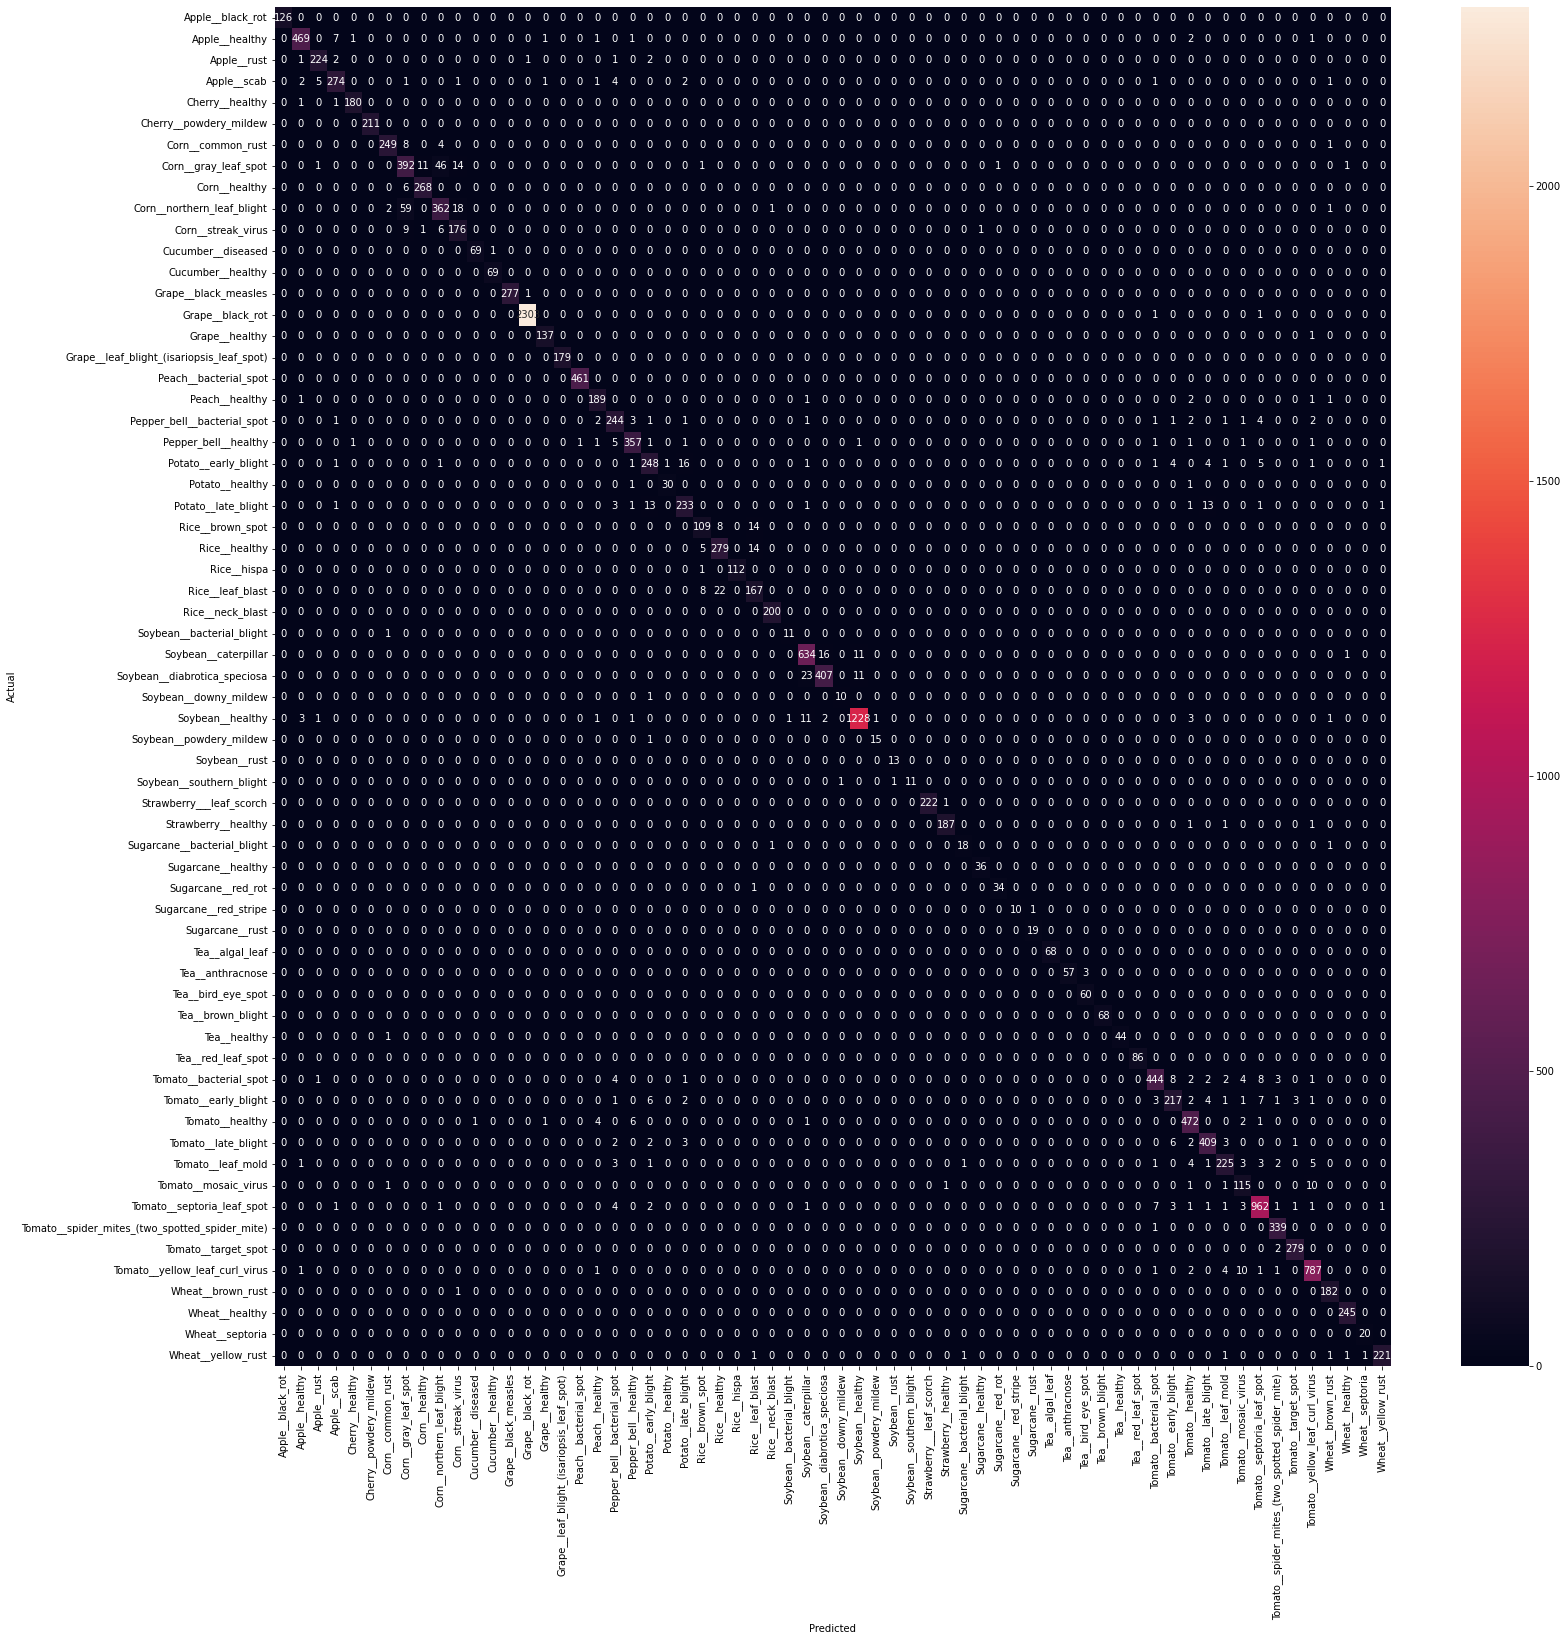

In [14]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# classification report
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=classes)
print(report)

                                                precision    recall  f1-score   support

                              Apple__black_rot       1.00      1.00      1.00       126
                                Apple__healthy       0.98      0.97      0.98       483
                                   Apple__rust       0.97      0.97      0.97       231
                                   Apple__scab       0.95      0.94      0.94       293
                               Cherry__healthy       0.99      0.99      0.99       182
                        Cherry__powdery_mildew       1.00      1.00      1.00       211
                             Corn__common_rust       0.98      0.95      0.97       262
                          Corn__gray_leaf_spot       0.83      0.84      0.83       467
                                 Corn__healthy       0.96      0.98      0.97       274
                    Corn__northern_leaf_blight       0.86      0.82      0.84       443
                            Cor

##### MobileNet_v2 Model Evaluation

In [16]:
MODEL_PATH = 'models/(trained_on_merged)MobileNetV2_20240418_000119/best_model.pth'
mobilenetv2_base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenetv2_base_model.classifier[1] = nn.Linear(mobilenetv2_base_model.last_channel, NUM_CLASSES)
mobilenetv2_model = load_model_from_local(mobilenetv2_base_model, MODEL_PATH)
mobilenetv2_model.eval()
mobilenetv2_model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenetv2_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

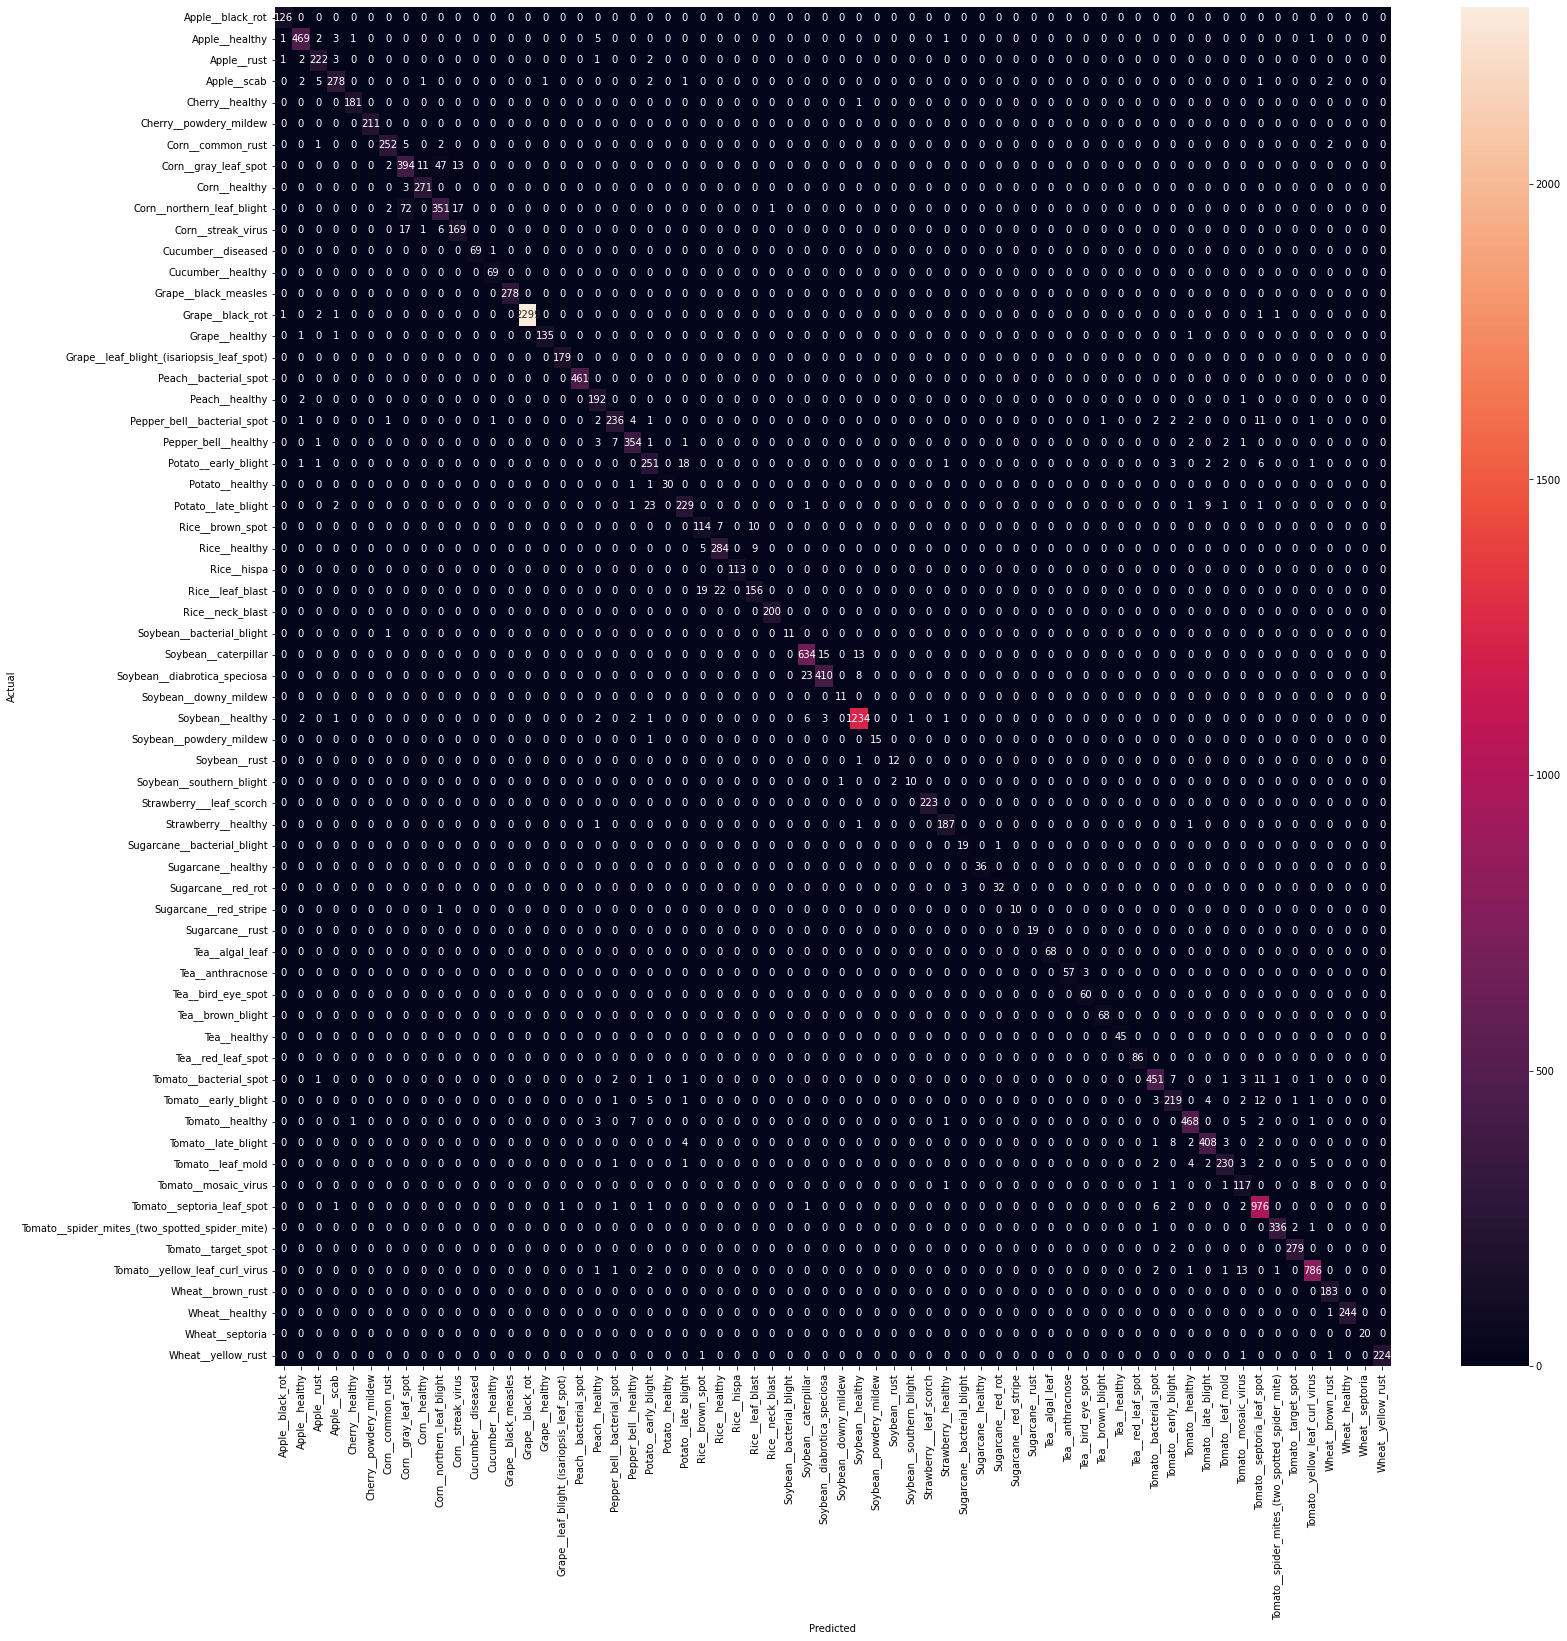

In [18]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
# classification report
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=classes)
print(report)

                                                precision    recall  f1-score   support

                              Apple__black_rot       0.98      1.00      0.99       126
                                Apple__healthy       0.98      0.97      0.97       483
                                   Apple__rust       0.94      0.96      0.95       231
                                   Apple__scab       0.96      0.95      0.95       293
                               Cherry__healthy       0.99      0.99      0.99       182
                        Cherry__powdery_mildew       1.00      1.00      1.00       211
                             Corn__common_rust       0.98      0.96      0.97       262
                          Corn__gray_leaf_spot       0.80      0.84      0.82       467
                                 Corn__healthy       0.95      0.99      0.97       274
                    Corn__northern_leaf_blight       0.86      0.79      0.83       443
                            Cor